In [18]:
import numpy as np  # 引入numpy、pandas库
import pandas as pd
from dbfread import DBF
from pandas import DataFrame
import matplotlib.pyplot as plt
import proplot as plot

import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from IPython.display import display

import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter  # 刻度格式
import matplotlib.ticker as mticker  # 添加网格线
import math
from matplotlib import patches
import os
from matplotlib import font_manager as fm, rcParams

pd.options.display.max_columns = None

# 1.筛选第一个到达最大值的点
# 2.去掉USE_WIND里面小于34的点，分别记录第一个最大值和最小值的点
# 3.画出两个时间段USE_WIND最小点 为ab图 输出点数
# 4.画出两个时间段USE_WIND最大点 为cd图

path = "./dataset/south_patric.dbf"
df_raw = pd.DataFrame(iter(DBF(path)))

df = df_raw[(df_raw['USA_STATUS'] != "EX") 
            & (df_raw['USA_STATUS'] != "SS") 
            & (df_raw['USA_STATUS'] != "PT") 
            & (df_raw['USA_STATUS'] != "IN")
            & (df_raw['USA_STATUS'] != "DS") 
            & (df_raw['USA_STATUS'] != "WV")
            & (df_raw['USA_STATUS'] != "ET") 
            & (df_raw['USA_STATUS'] != "MD") 
            & (df_raw['USA_STATUS'] != "XX")]# 去掉表格属性USA_STATUS为EX的数据

df = df[df['DIST2LAND'] > 0] # 去掉陆地点

df = df[(df['month'] <5) | (df['month'] >10)]

df['LON'] = df['LON'].mask(df['LON'] < 0,(df['LON'] + 360))

def min_index(min_value, df_min):
    # 找出第一个出现最小值的index
    val_list = []
    val_list.append(min_value)
    val_list.append("end")
    # 获取基于条件的第一条
    index = df_min.USA_WIND.isin(val_list).idxmax()
    return index

def year_min_Lon_Lat(df_, year):
    # 筛选本年度year的最小台风的经纬度
    df_year = df_[df_['year'] == year]
    # 筛选风速大于34
    df_typhSpeed_moreThan_34 = df_year[df_year['USA_WIND'] >= 34]
    # 列出台风编号
    typh_number = list(set(df_typhSpeed_moreThan_34['NUMBER']))
    df_year_Lon_Lat = pd.DataFrame(columns=['YEAR','NUMBER','LON','LAT','MAX'], index=None)
    # 根据编号等于1的所有台风

    for number in typh_number:
        df_min = df_typhSpeed_moreThan_34[df_typhSpeed_moreThan_34['NUMBER']==number]
        # 查找当前台风的风速的最小值
        typh_num_min = df_min.USA_WIND.min()
        typh_num_max = df_min.USA_WIND.max()
        typh_num_min_index = min_index(typh_num_min, df_min)
        min_lon = df_min.at[typh_num_min_index, "LON"]
        min_lat = df_min.at[typh_num_min_index, "LAT"]
        MAX = typh_num_max
        tmp = [year, number, min_lon, min_lat, MAX]
        df_year_Lon_Lat.loc[len(df_year_Lon_Lat)] = tmp
        df_year_Lon_Lat['YEAR']=df_year_Lon_Lat['YEAR'].astype(int)
        df_year_Lon_Lat['NUMBER']=df_year_Lon_Lat['NUMBER'].astype(int)
        df_year_Lon_Lat['MAX']=df_year_Lon_Lat['MAX'].astype(int)
    return df_year_Lon_Lat



In [19]:
ls_er = [1983, 1987, 1988, 1992, 1995, 1998, 2003, 2005, 2010, 2015, 2016, 2019, 2020]

ls_lani = [1984, 1985, 1989, 1996, 1999, 2000, 2001,2006, 2008, 2009, 2011, 2012, 2018, 2021, 2022, 2023]

ls_netu = [1979, 1980, 1981, 1982, 1986, 1990, 1991, 1993, 1994, 1997, 2002, 2004, 2007, 2013, 2014, 2017]

df_er = pd.DataFrame(columns=['YEAR','NUMBER','LON','LAT','MAX'])
for year in ls_er:
    df_tmp = year_min_Lon_Lat(df, year)
    df_er = pd.concat([df_er,df_tmp], ignore_index=True)

df_lani = pd.DataFrame(columns=['YEAR','NUMBER','LON','LAT','MAX'])
for year in ls_lani:
    df_tmp = year_min_Lon_Lat(df, year)
    df_lani = pd.concat([df_lani,df_tmp], ignore_index=True)

df_netu = pd.DataFrame(columns=['YEAR','NUMBER','LON','LAT','MAX'])
for year in ls_netu:
    df_tmp = year_min_Lon_Lat(df, year)
    df_netu = pd.concat([df_netu, df_tmp], ignore_index=True)



/tmp/ipykernel_2791428/3393831380.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_er = pd.concat([df_er,df_tmp], ignore_index=True)
/tmp/ipykernel_2791428/3393831380.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_lani = pd.concat([df_lani,df_tmp], ignore_index=True)
/tmp/ipykernel_2791428/3393831380.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns whe

In [22]:
def lon_less_360(df_t):
    mean = 0
    for i in range(len(df_t['LON'])):
        if df_t['LON'][i] >=0:
            mean += df_t['LON'][i]
        else:
            mean = mean + df_t['LON'][i] + 360

    return mean / len(df_t['LON'])
   
    
print("厄尔尼诺经纬度(%f, %f)"%(lon_less_360(df_er), df_er['LAT'].mean()))
print("拉尼娜经纬度(%f, %f)"%(lon_less_360(df_lani), df_lani['LAT'].mean()))
print("中性经纬度(%f, %f)"%(lon_less_360(df_netu), df_netu['LAT'].mean()))

厄尔尼诺经纬度(173.209343, -14.564818)
拉尼娜经纬度(164.303817, -16.685420)
中性经纬度(165.817647, -15.711242)


In [23]:
print("厄尔尼诺经纬度(%.2f, %.2f)"%(df_er['LON'].mean(), df_er['LAT'].mean()))
print("拉尼娜经纬度(%f, %f)"%(df_lani['LON'].mean(), df_lani['LAT'].mean()))
print("中性经纬度(%f, %f)"%(df_netu['LON'].mean(), df_netu['LAT'].mean()))

厄尔尼诺经纬度(173.21, -14.56)
拉尼娜经纬度(164.303817, -16.685420)
中性经纬度(165.817647, -15.711242)


In [24]:
df_er_less63 = df_er[df_er['MAX'] <= 63]
df_er_more63 = df_er[df_er['MAX'] > 63]



/tmp/ipykernel_2791428/1988632494.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_er_less63['LON'] = df_er_less63['LON'].mask(df_er_less63['LON'] < 0,(df_er_less63['LON'] + 360))


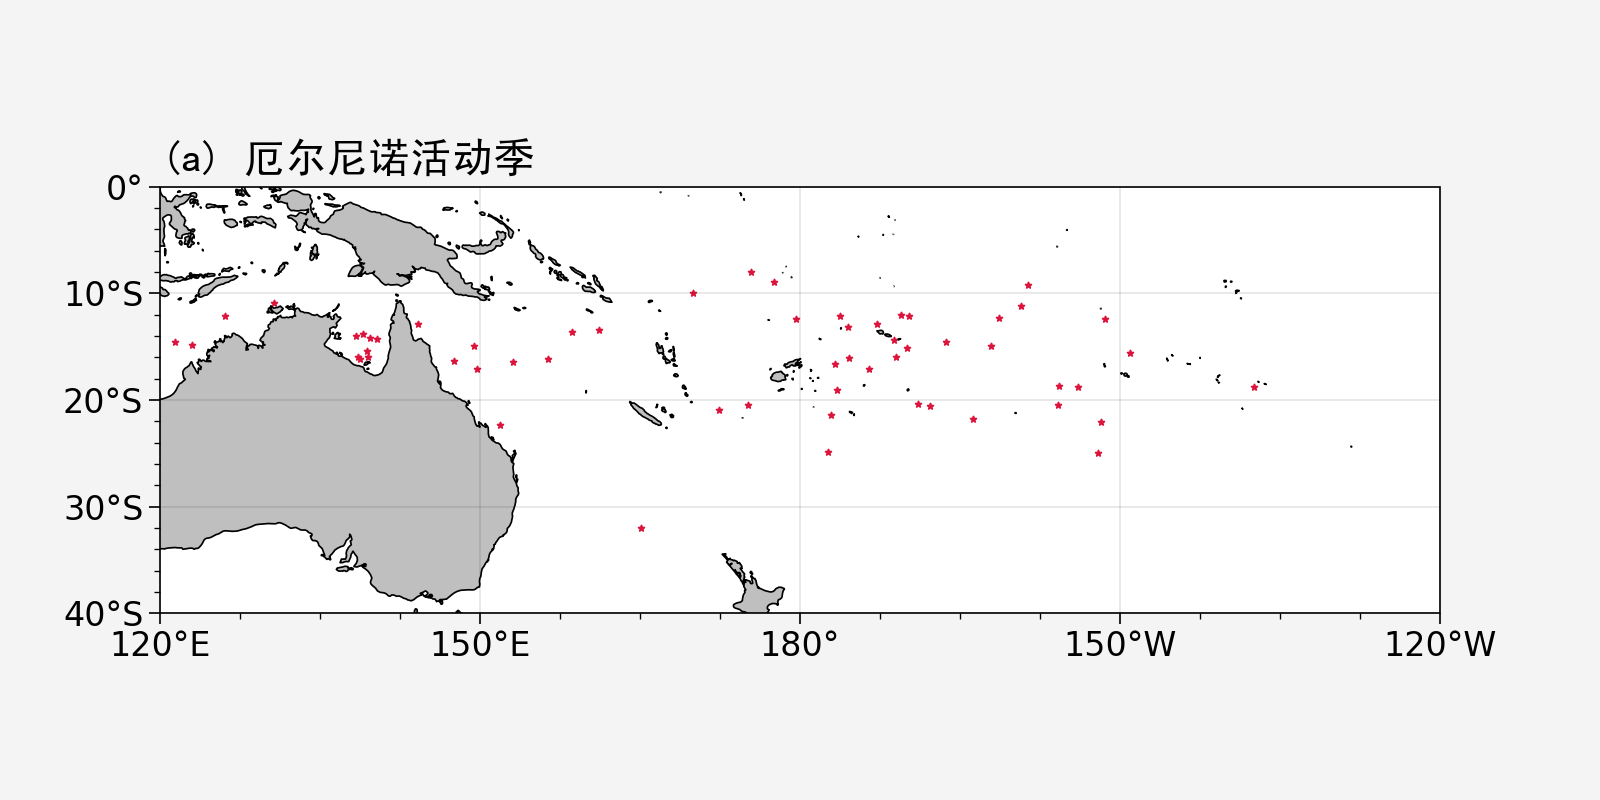

In [27]:
from matplotlib import rcParams
from matplotlib import patches
import cartopy.mpl.ticker as cticker
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

config = {
    "font.family": 'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
fig = plt.figure(figsize=(8,4))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

####### 图a
fig_ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection = proj)
fig_ax1.set_global()
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())

fig_ax1.xaxis.set_major_formatter(LongitudeFormatter())
fig_ax1.yaxis.set_major_formatter(LatitudeFormatter())

fig_ax1.set_title('(a) 厄尔尼诺活动季',fontweight='bold',
                  loc='left',fontsize =15,fontproperties='SimHei')

fig_ax1.scatter(df_er_less63['LON'], df_er_less63['LAT'],
        s=5, c = '#DC143C', marker = '*', 
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_er_less63['LON'] = df_er_less63['LON'].mask(df_er_less63['LON'] < 0,(df_er_less63['LON'] + 360))

plt.savefig("Storm0402_er_less63.png",dpi=300,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2791428/1121761603.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_er_more63['LON'] = df_er_more63['LON'].mask(df_er_more63['LON'] < 0,(df_er_more63['LON'] + 360))


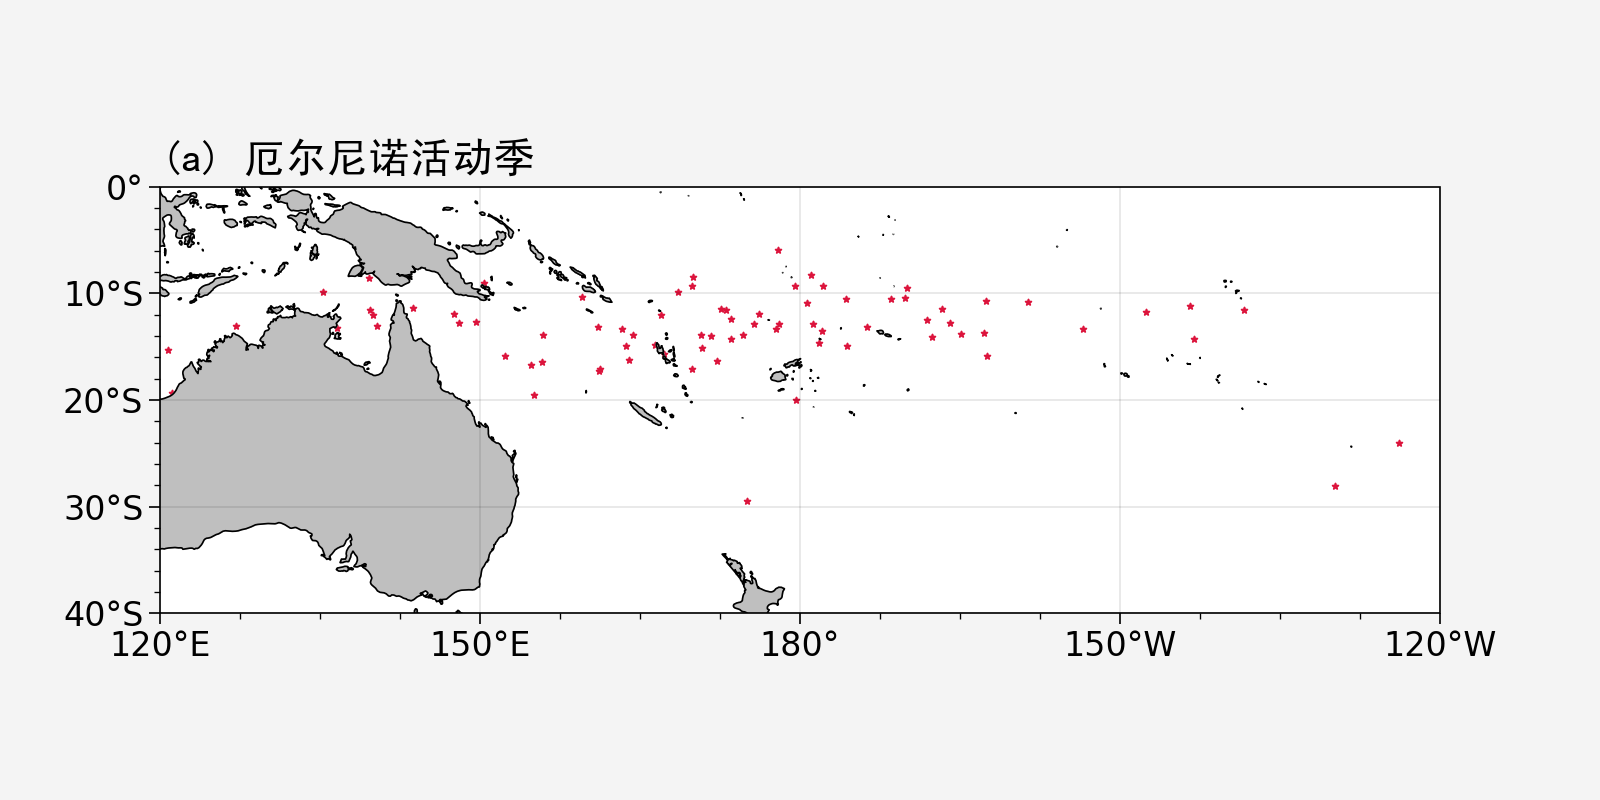

In [28]:
from matplotlib import rcParams
from matplotlib import patches
import cartopy.mpl.ticker as cticker
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

config = {
    "font.family": 'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
fig = plt.figure(figsize=(8,4))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

####### 图a
fig_ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection = proj)
fig_ax1.set_global()
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())

fig_ax1.xaxis.set_major_formatter(LongitudeFormatter())
fig_ax1.yaxis.set_major_formatter(LatitudeFormatter())

fig_ax1.set_title('(a) 厄尔尼诺活动季',fontweight='bold',
                  loc='left',fontsize =15,fontproperties='SimHei')

fig_ax1.scatter(df_er_more63['LON'], df_er_more63['LAT'],
        s=5, c = '#DC143C', marker = '*', 
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_er_more63['LON'] = df_er_more63['LON'].mask(df_er_more63['LON'] < 0,(df_er_more63['LON'] + 360))

plt.savefig("Storm0402_er_more63.png",dpi=300,bbox_inches='tight')
plt.show()

In [25]:
df_lani_less63 = df_lani[df_lani['MAX'] <= 63]
df_lani_more63 = df_lani[df_lani['MAX'] > 63]



/tmp/ipykernel_2791428/3547748851.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lani_less63['LON'] = df_lani_less63['LON'].mask(df_lani_less63['LON'] < 0,(df_lani_less63['LON'] + 360))


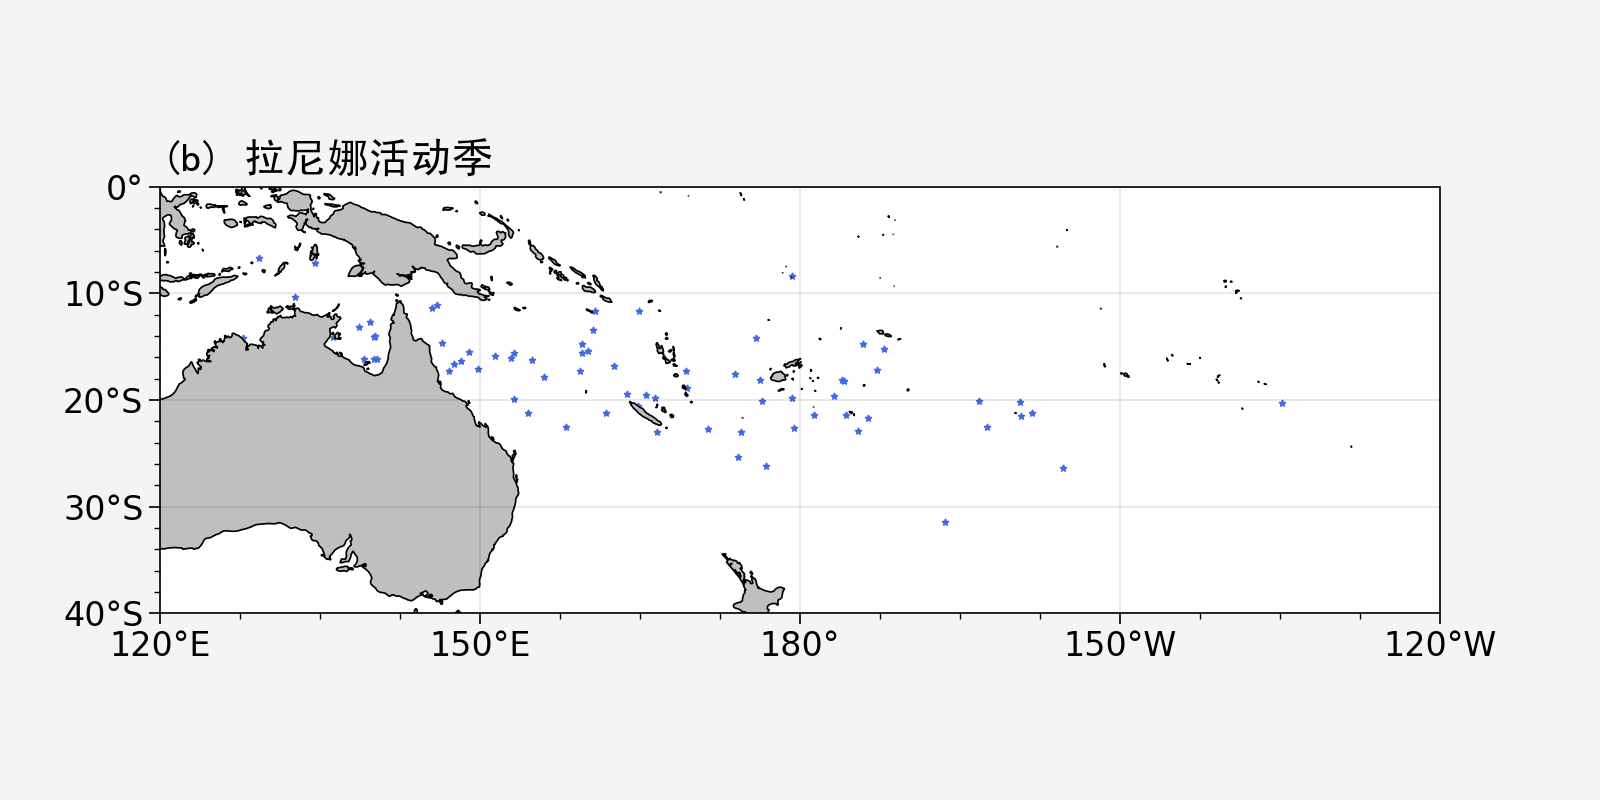

In [29]:
from matplotlib import rcParams
from matplotlib import patches
import cartopy.mpl.ticker as cticker
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

config = {
    "font.family": 'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
fig = plt.figure(figsize=(8,4))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

####### 图a
fig_ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection = proj)
fig_ax1.set_global()
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())

fig_ax1.xaxis.set_major_formatter(LongitudeFormatter())
fig_ax1.yaxis.set_major_formatter(LatitudeFormatter())

fig_ax1.set_title('(b) 拉尼娜活动季',fontweight='bold',
                  loc='left',fontsize =15,fontproperties='SimHei')

fig_ax1.scatter(df_lani_less63['LON'], df_lani_less63['LAT'],
        s=5, c = '#4169E1', marker = '*', 
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_lani_less63['LON'] = df_lani_less63['LON'].mask(df_lani_less63['LON'] < 0,(df_lani_less63['LON'] + 360))

plt.savefig("Storm0402_lani_less63.png",dpi=300,bbox_inches='tight')
plt.show()

/tmp/ipykernel_2791428/3643985842.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_lani_more63['LON'] = df_lani_more63['LON'].mask(df_lani_more63['LON'] < 0,(df_lani_more63['LON'] + 360))


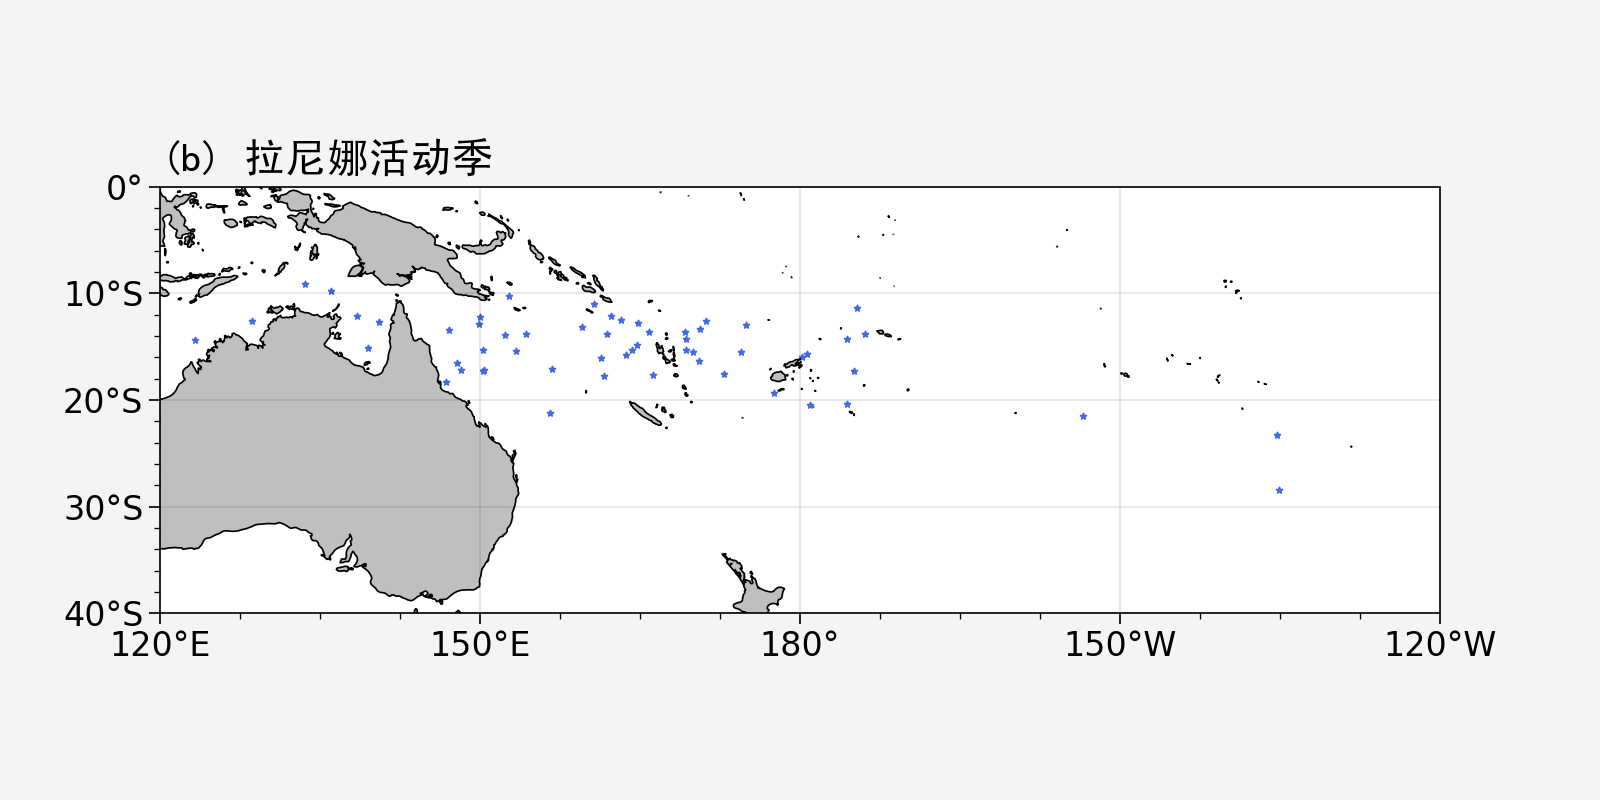

In [30]:
from matplotlib import rcParams
from matplotlib import patches
import cartopy.mpl.ticker as cticker
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

config = {
    "font.family": 'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
fig = plt.figure(figsize=(8,4))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

####### 图a
fig_ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection = proj)
fig_ax1.set_global()
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())

fig_ax1.xaxis.set_major_formatter(LongitudeFormatter())
fig_ax1.yaxis.set_major_formatter(LatitudeFormatter())

fig_ax1.set_title('(b) 拉尼娜活动季',fontweight='bold',
                  loc='left',fontsize =15,fontproperties='SimHei')

fig_ax1.scatter(df_lani_more63['LON'], df_lani_more63['LAT'],
        s=5, c = '#4169E1', marker = '*', 
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
df_lani_more63['LON'] = df_lani_more63['LON'].mask(df_lani_more63['LON'] < 0,(df_lani_more63['LON'] + 360))

plt.savefig("Storm0402_lani_more63.png",dpi=300,bbox_inches='tight')
plt.show()

In [26]:
df_netu_less63 = df_netu[df_netu['MAX'] <= 63]
df_netu_more63 = df_netu[df_netu['MAX'] > 63]


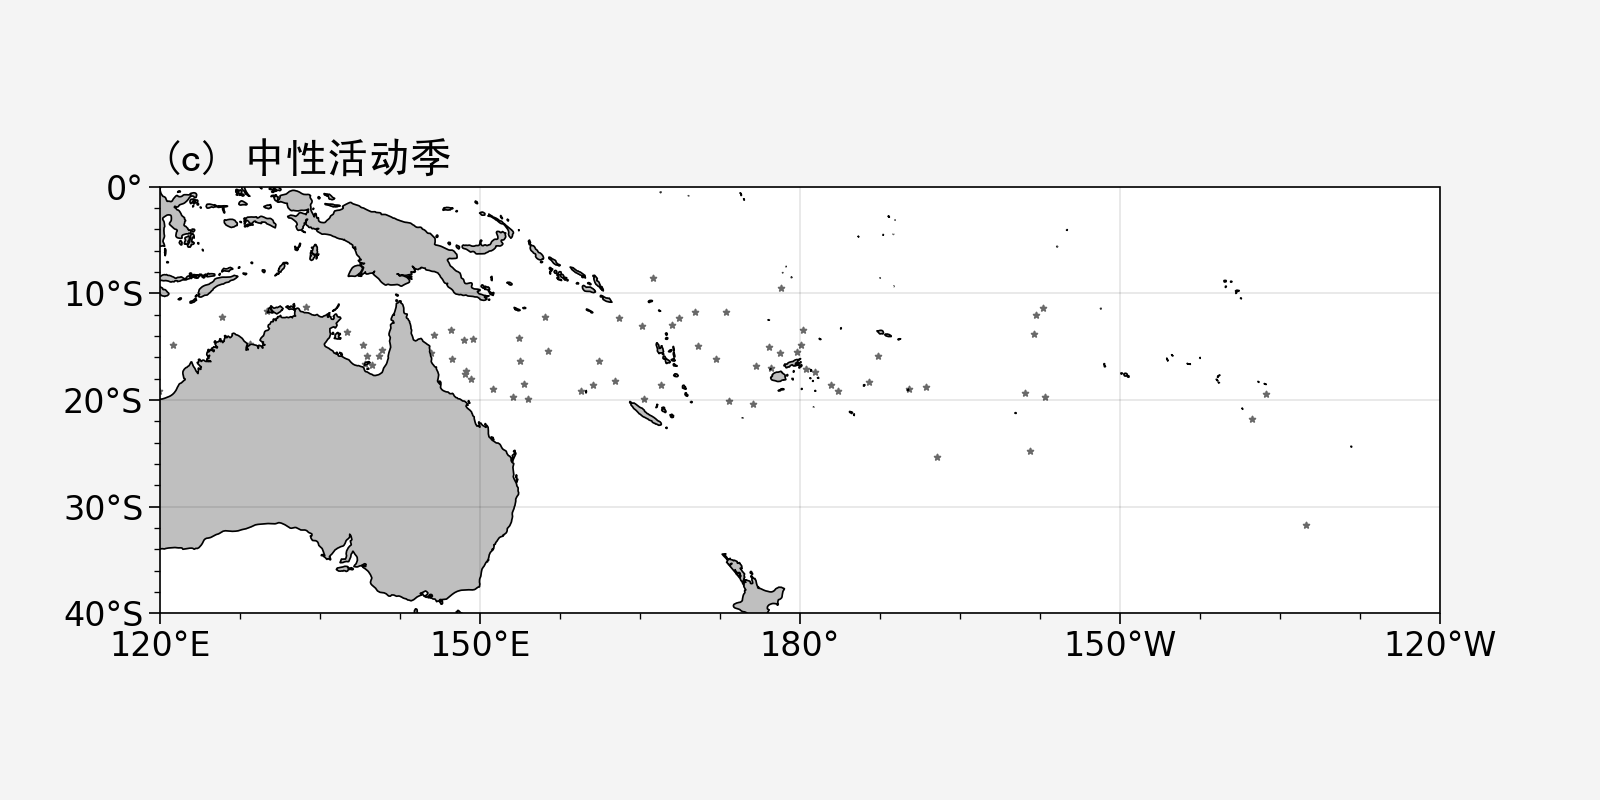

In [32]:
from matplotlib import rcParams
from matplotlib import patches
import cartopy.mpl.ticker as cticker
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

config = {
    "font.family": 'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
fig = plt.figure(figsize=(8,4))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

####### 图a
fig_ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection = proj)
fig_ax1.set_global()
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())

fig_ax1.xaxis.set_major_formatter(LongitudeFormatter())
fig_ax1.yaxis.set_major_formatter(LatitudeFormatter())

fig_ax1.set_title('(c) 中性活动季',fontweight='bold',
                  loc='left',fontsize =15,fontproperties='SimHei')

fig_ax1.scatter(df_netu_less63['LON'], df_netu_less63['LAT'],
        s=5, c = '#696969', marker = '*', 
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
# df_netu_less63['LON'] = df_netu_less63['LON'].mask(df_netu_less63['LON'] < 0,(df_netu_less63['LON'] + 360))

plt.savefig("Storm0402_netu_less63.png",dpi=300,bbox_inches='tight')
plt.show()

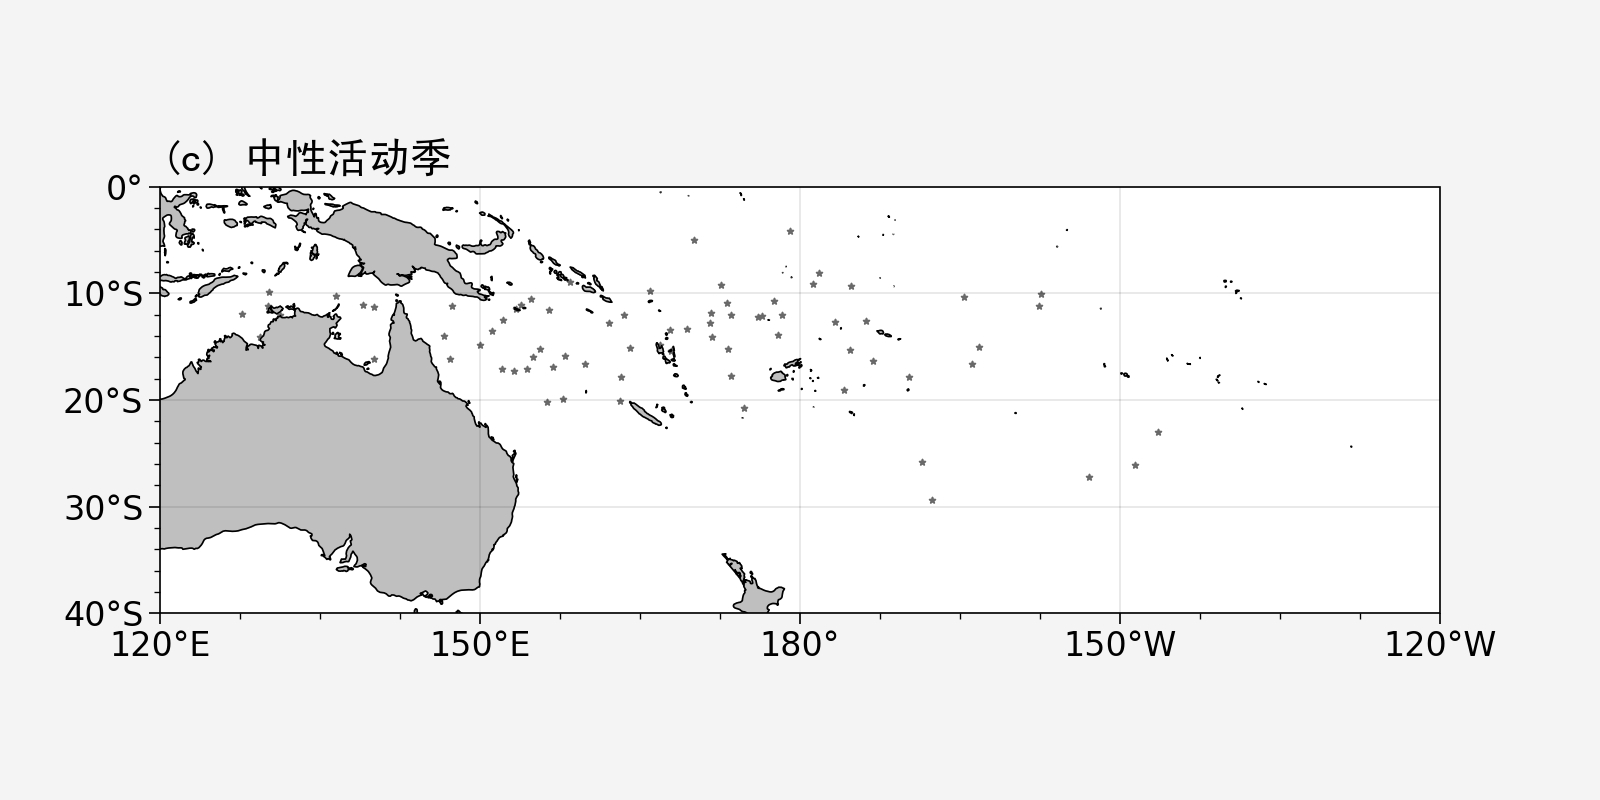

In [31]:
from matplotlib import rcParams
from matplotlib import patches
import cartopy.mpl.ticker as cticker
import matplotlib

matplotlib.font_manager.fontManager.addfont('./font/SimHei.ttf') 
plt.rcParams['font.sans-serif']=['SimHei'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False#用来正常显示负号

config = {
    "font.family": 'Times New Roman',
    "font.size": 12,
    "mathtext.fontset":'stix',
    'axes.unicode_minus': False 
         }
rcParams.update(config)
fig = plt.figure(figsize=(8,4))
proj = ccrs.PlateCarree(central_longitude=180)

leftlon, rightlon, lowerlat, upperlat = (120, 240, -40, 0)
lon_formatter = cticker.LongitudeFormatter()
lat_formatter = cticker.LatitudeFormatter()

####### 图a
fig_ax1 = fig.add_axes([0.1, 0.1, 0.8, 0.8], projection = proj)
fig_ax1.set_global()
fig_ax1.set_extent([leftlon, rightlon, lowerlat, upperlat], crs=ccrs.PlateCarree())
land = cfeature.NaturalEarthFeature('physical','land','50m',edgecolor='face', facecolor=cfeature.COLORS['land'])
fig_ax1.add_feature(land,facecolor='0.75')
fig_ax1.add_feature(cfeature.COASTLINE.with_scale('50m'))

fig_ax1.set_xticks([ -150, -120, 120, 150, 180], crs=ccrs.PlateCarree())
fig_ax1.set_yticks(np.arange(-40,1,10), crs=ccrs.PlateCarree())

fig_ax1.xaxis.set_major_formatter(LongitudeFormatter())
fig_ax1.yaxis.set_major_formatter(LatitudeFormatter())

fig_ax1.set_title('(c) 中性活动季',fontweight='bold',
                  loc='left',fontsize =15,fontproperties='SimHei')

fig_ax1.scatter(df_netu_more63['LON'], df_netu_more63['LAT'],
        s=5, c = '#696969', marker = '*', 
        transform=ccrs.PlateCarree())
# 小于0的数均加上360
# df_netu_more63['LON'] = df_netu_more63['LON'].mask(df_netu_more63['LON'] < 0,(df_netu_more63['LON'] + 360))

plt.savefig("Storm0402_netu_more63.png",dpi=300,bbox_inches='tight')
plt.show()

In [33]:
df_er.to_excel("./df_er.xlsx")
df_er_less63.to_excel("./df_er_less63.xlsx")
df_er_more63.to_excel("./df_er_more63.xlsx")
df_lani.to_excel("./df_lani.xlsx")
df_lani_less63.to_excel("./df_lani_less63.xlsx")
df_lani_more63.to_excel("./df_lani_more63.xlsx")
df_netu.to_excel("./df_netu.xlsx")
df_netu_less63.to_excel("./df_netu_less63.xlsx")
df_netu_more63.to_excel("./df_netu_more63.xlsx")


/tmp/ipykernel_2791428/1465456386.py:1: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  df_er.to_excel("./df_er.xlsx")
/tmp/ipykernel_2791428/1465456386.py:2: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  df_er_less63.to_excel("./df_er_less63.xlsx")
/tmp/ipykernel_2791428/1465456386.py:3: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  df_er_more63.to_excel("./df_er_more63.xlsx")
/tmp/ipykernel_2791428/1465456386.py:4: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  df_lani.to_excel("./df_lani.xlsx")
/tmp/ipykernel_2791428/1465456386.py:5: UserWarning: Pandas requires version '3.0.5' or newer of 'xlsxwriter' (version '3.0.1' currently installed).
  df_lani_less63.to_excel("./df_lani_less63.xlsx")
/tmp/ipykernel_2791428/1465456386.py:6: 

In [35]:
df_er['LON']

0      149.68
1      171.70
2      172.42
3      155.93
4      216.93
        ...  
132    154.75
133    179.60
134    159.54
135    173.50
136    186.50
Name: LON, Length: 137, dtype: float64

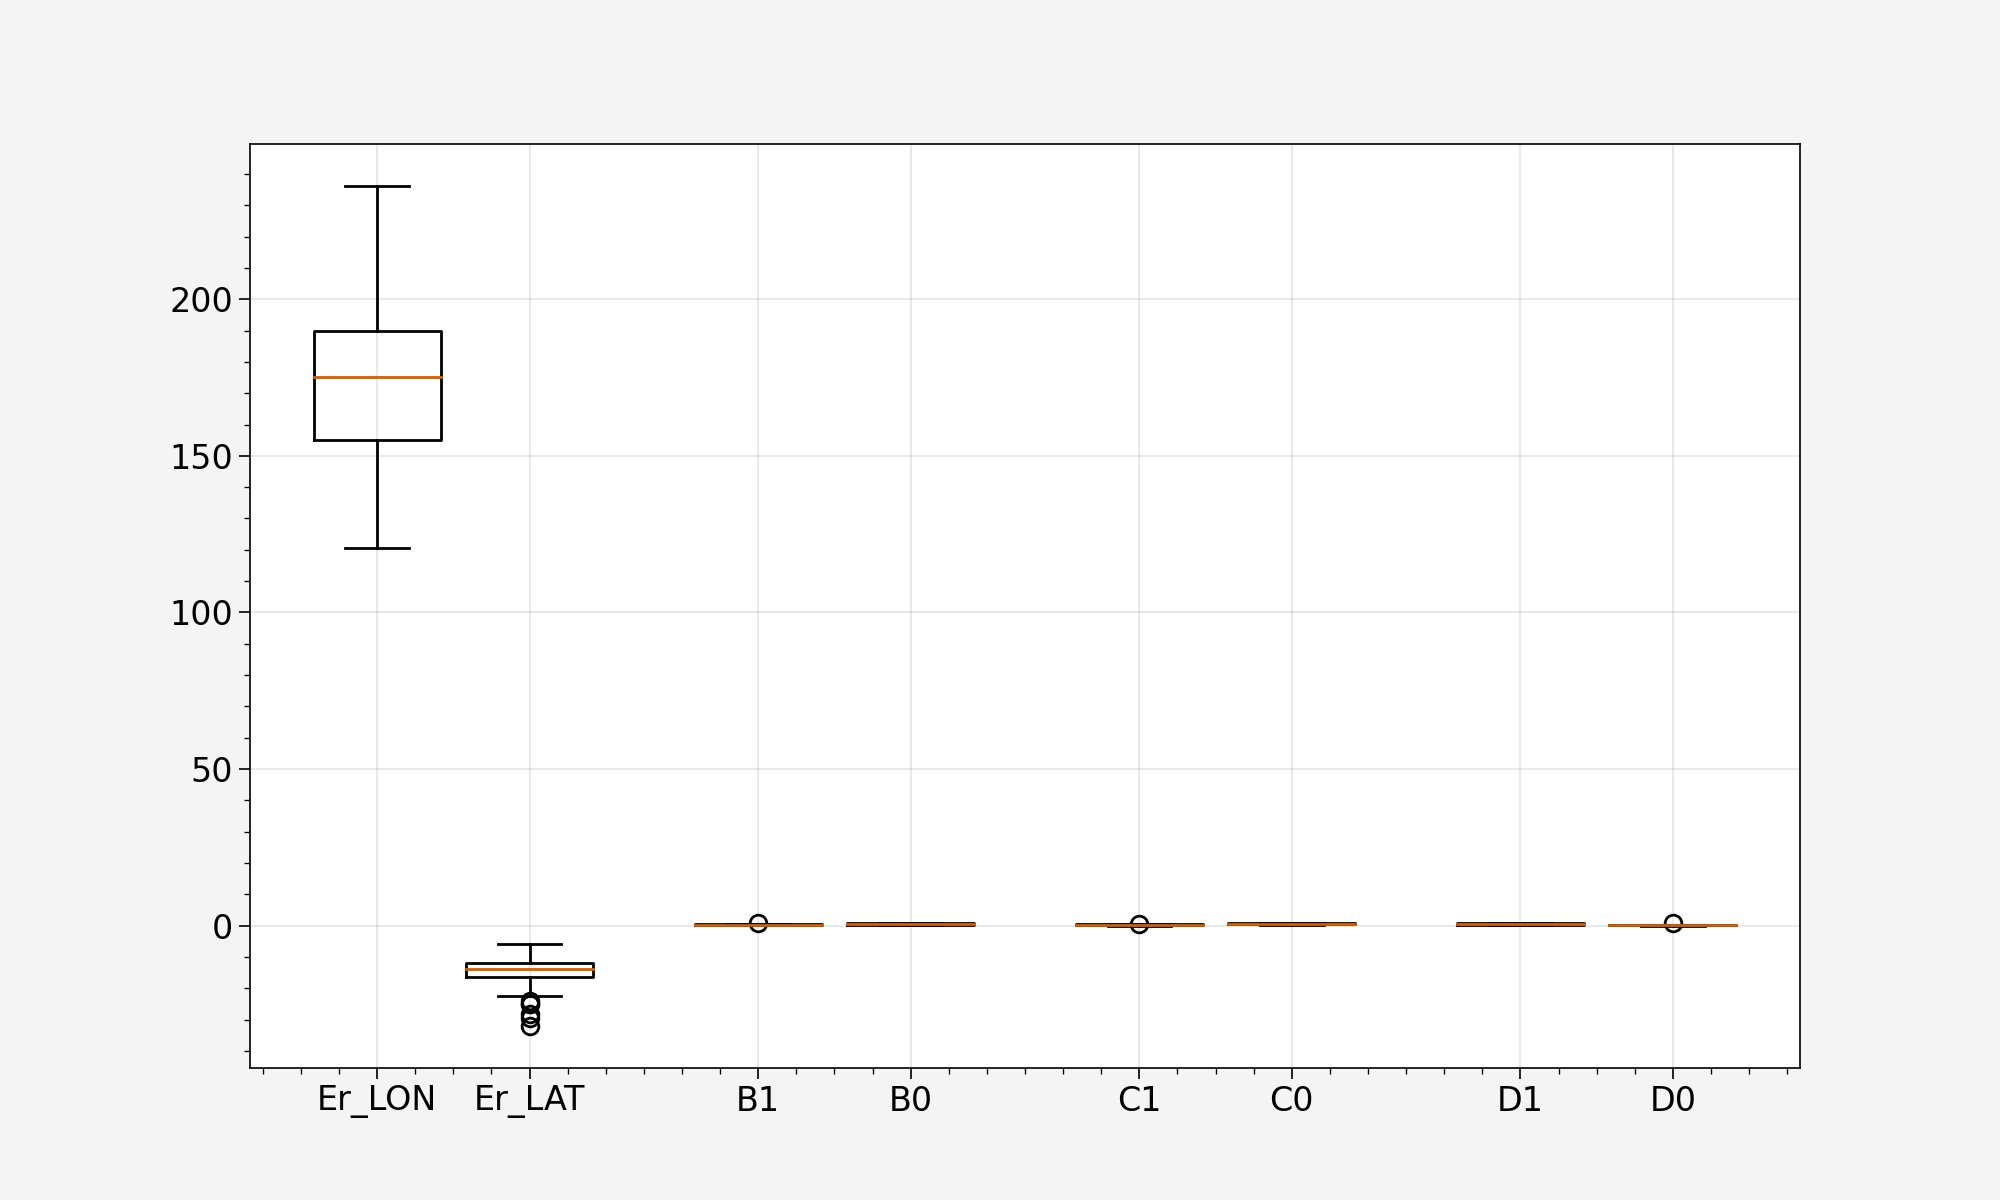

In [39]:

import matplotlib.pyplot as plt


df = pd.DataFrame(np.random.rand(10,4), columns=list('ABCD'))
df['E'] = [1, 2, 1, 1, 1, 2, 1, 2, 2, 1]

mask_e = df['E'] == 1

# prepare data
data_to_plot = [df_er['LON'], df_er['LAT'],
                df[mask_e]['B'], df[~mask_e]['B'],
                df[mask_e]['C'], df[~mask_e]['C'],
                df[mask_e]['D'], df[~mask_e]['D']]

# Positions defaults to range(1, N+1) where N is the number of boxplot to be drawn.
# we will move them a little, to visually group them
plt.figure(figsize=(10, 6))
box = plt.boxplot(data_to_plot,
                  positions=[1, 1.6, 2.5, 3.1, 4, 4.6, 5.5, 6.1],
                  labels=['Er_LON','Er_LAT','B1','B0','C1','C0','D1','D0'])

ValueError: The number of FixedLocator locations (3), usually from a call to set_ticks, does not match the number of ticklabels (6).

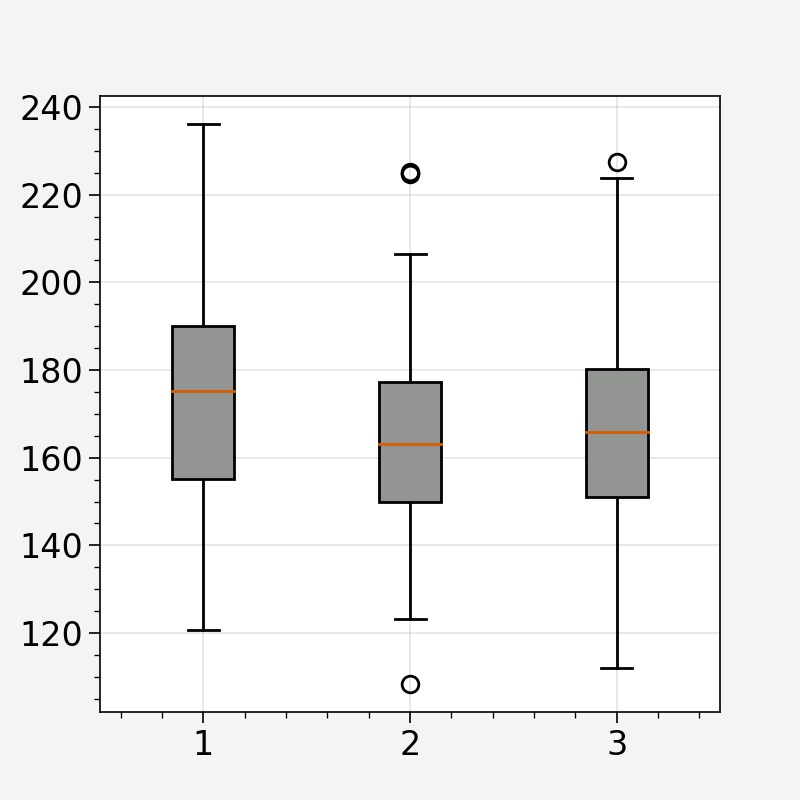

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(np.random.randn(100, 6), columns=['Er_LON','Er_LAT','B1','B0','C1','C0'])

fig, ax1 = plt.subplots()
colors = ['pink', 'lightblue', 'lightgreen', 'purple']
bp = ax1.boxplot([df_er['LON'],df_lani['LON'],df_netu['LON']], patch_artist=True, boxprops=dict(facecolor='gray'))
ax1.set_xticklabels(['Er_LON','Er_LAT','B1','B0','C1','C0'])
ax1.set_ylabel('y1')

ax2 = ax1.twinx()

bp = ax2.boxplot([df_er['LAT'],df_lani['LAT'],df_netu['LAT']], patch_artist=True, boxprops=dict(facecolor='gray'))
# ax2.set_xticklabels(df.columns)
ax2.set_ylabel('y2')

ax1.set_ylim([0, 360])
ax2.set_ylim([-90, 0])

for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    
plt.legend([bp["boxes"][0], bp["boxes"][2]], ['y1', 'y2'], loc='upper right')

plt.show()

In [51]:
df.values.shape

(100, 6)